> **!! Important**: Remember to run `0 Prepare Data` first!

In [1]:
%run common.ipy

Using DW in /home/davo/Documents/GRASIA/daostack-notebooks/datawarehouse from date 2023-05-01T00:00:00
DW version 1.1.9
dao-analyzer version: 1.2.6
cache-scripts version: 1.1.9


In [2]:
# Data tools
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import unicodedata

# Jupyter
import ipywidgets as widgets

# Local modules
import utils

utils.DEFAULT_REGISTERED_ONLY = True
# plt.style.use('dark_background')

%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.plot

## ¿Es el boosting un buen predictor?

Vamos a calcular la precisión y el recall en el tiempo, tanto para mainnet como xdai

In [3]:
dfp = utils.get_df('dfp')
print(dfp.dtypes)
print("Stages:", dfp.stage.cat.categories.tolist())

# Esto es igual a poner ~dfp.executedAt.isna()
dfp = dfp[dfp.stage.isin([
    "Executed",        # Ha sido ejecutada, puede ser aprobada o no, boosteada o no
    "ExpiredInQueue",  # Tras mucho tiempo en la cola, no ha conseguido ni mayoría absoluta ni ser boosteada
])]

print("Total:", len(dfp), "propuestas")

# Eliminar "competition" (se hace voto entre varias opciones, no tienen por qué ser Sí y No)
dfpr = dfp[ dfp['competitionId'].isnull() ].copy().reset_index()

print("There are", (dfpr['stakesFor'] == dfpr['stakesAgainst']).sum(), "ties")

dfpr['stakes'] = dfpr['stakesFor'] > dfpr['stakesAgainst']
dfpr['boosted'] = ~dfpr['boostedAt'].isnull()
dfpr['approved'] = dfpr['winningOutcome'] == 'Pass'

%pickledf dfpr
dfpr[['approved', 'stakes', 'boosted']].value_counts()

proposer                                 string
stage                                  category
createdAt                        datetime64[ns]
preBoostedAt                     datetime64[ns]
boostedAt                        datetime64[ns]
quietEndingPeriodBeganAt         datetime64[ns]
closingAt                                object
preBoostedClosingAt              datetime64[ns]
executedAt                       datetime64[ns]
totalRepWhenExecuted                     object
totalRepWhenCreated                      object
executionState                         category
expiresInQueueAt                 datetime64[ns]
votesFor                                 object
votesAgainst                             object
winningOutcome                         category
stakesFor                               Float64
stakesAgainst                           Float64
title                                    string
description                              string
url                                     

approved  stakes  boosted
True      True    True       2796
False     False   False       502
True      False   False       376
False     True    True         57
True      True    False        48
False     True    False        23
dtype: int64

In [4]:
def plot_classification_report_2x2(df: pd.DataFrame, suptitle: str='Classification report', supy: str='network'):
    Y_AVAILABLE = sorted(df[supy].unique())
    PREDICTORES = ['stakes', 'boosted']
    
    fig, axs = plt.subplots(ncols=len(Y_AVAILABLE), nrows=2, sharex=True, sharey=True, tight_layout=True)
    
    fig.suptitle(suptitle)
    fig.supxlabel("Predictor")
    fig.supylabel(supy.capitalize())
    
    print("y_true = approved, y_pred = boosted")
    print(classification_report(y_true=df['approved'], y_pred=df['boosted'], zero_division=0))
    for i, n in enumerate(Y_AVAILABLE):
        dfprn = df[df[supy] == n]
        print(f"## {n} only ##")
        print(classification_report(y_true=dfprn['approved'], y_pred=dfprn['boosted'], zero_division=0))
        for j, p in enumerate(PREDICTORES):
            ct = pd.crosstab(dfprn['approved'], dfprn[p]).sort_index(ascending=False).sort_index(axis='columns', ascending=False)
            if True not in ct.columns:
                ct[True] = 0
                
            sns.heatmap(ct, annot=True, fmt='d', ax=axs[i][j], cmap=utils.plot.default_heatmap_cmap, square=True)

            # Hide labels on the middle
            axs[i][j].set_xlabel(axs[i][j].get_xlabel() if i != 0 else '')
            axs[i][j].set_ylabel(f"{n}\n{axs[i][j].get_ylabel()}" if j == 0 else '')
            
    plt.close()
    return fig

def plot_classification_report_2x1(df: pd.DataFrame, suptitle: str='Classification report', supx: str='network'):
    X_AVAILABLE = sorted(df[supx].unique())
    
    fig, axs = plt.subplots(ncols=len(X_AVAILABLE), nrows=1, sharex=True, sharey=True) #, tight_layout=True)
    
    fig.suptitle(suptitle)
    fig.supxlabel(supx.capitalize())
    
    print("y_true = approved, y_pred = boosted")
    print(classification_report(y_true=df['approved'], y_pred=df['boosted'], zero_division=0))
    for i, n in enumerate(X_AVAILABLE):
        dfprn = df[df[supx] == n]
        print(f"## {n} only ##")
        print(classification_report(y_true=dfprn['approved'], y_pred=dfprn['boosted'], zero_division=0))
        
        ct = pd.crosstab(dfprn['approved'], dfprn['boosted']).sort_index(ascending=False).sort_index(axis='columns', ascending=False)
        sns.heatmap(ct, annot=True, fmt='d', ax=axs[i], cmap=utils.plot.default_heatmap_cmap, square=True)
        axs[i].set_title(n)
            
    plt.close()
    return fig

y_true = approved, y_pred = boosted
              precision    recall  f1-score   support

       False       0.55      0.90      0.69       582
        True       0.98      0.87      0.92      3220

    accuracy                           0.87      3802
   macro avg       0.77      0.89      0.80      3802
weighted avg       0.91      0.87      0.88      3802

## mainnet only ##
              precision    recall  f1-score   support

       False       0.52      0.91      0.66       469
        True       0.97      0.79      0.87      1874

    accuracy                           0.81      2343
   macro avg       0.75      0.85      0.77      2343
weighted avg       0.88      0.81      0.83      2343

## xdai only ##
              precision    recall  f1-score   support

       False       0.76      0.85      0.80       113
        True       0.99      0.98      0.98      1346

    accuracy                           0.97      1459
   macro avg       0.87      0.91      0.89      1459
wei

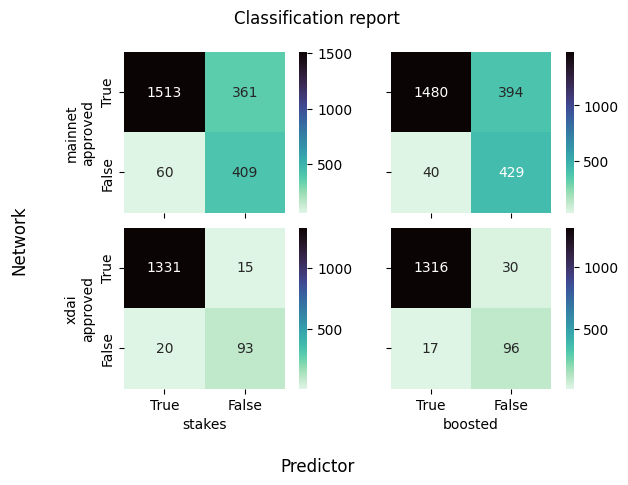

In [5]:
plot_classification_report_2x2(dfpr, suptitle='Classification report')

In [6]:
# plot_classification_report_2x2(dfpr[dfpr['daoRegister'] == 'registered'], suptitle='Classification report (registered only=old)')

In [7]:
# plot_classification_report_2x2(dfpr[dfpr['daoRegister'] == 'na'], suptitle='Classification report (na only)')

Tanto en mainnet como en xdai, hay un 20-25% de propuestas que acaban ganando pero no son boosteadas (ni stakeadas), lo que hará que el recall esté en torno al 80%. De las propuestas que no ganan, el recall parece estar en torno al 50%, además de que hay muy poco soporte. Sí que tiene una precisión muy alta, pero es porque a penas hay propuestas que no salgan...

In [8]:
_dfpr = dfpr.copy()
_dfpr = _dfpr[~_dfpr.executedAt.isna()]
_toplot = _dfpr.groupby(['createdAtMonth', 'daoRegister']).size().reset_index(name='count') #.pivot(columns='daoRegister', index='createdAtMonth', values=0)
_toplot['createdAtMonth'] = _toplot['createdAtMonth'].dt.strftime('%Y-%m')

px.bar(
    _toplot,
    x='createdAtMonth',
    y='count',
    color='daoRegister',
    title='Propuestas creadas mes a mes por estado de DAO',
)

In [9]:
_dfpr = dfpr.copy()
_dfpr = _dfpr[~_dfpr.executedAt.isna()]
_toplot = _dfpr.groupby(['createdAtMonth', 'network']).size().reset_index(name='count')
_toplot['createdAtMonth'] = _toplot['createdAtMonth'].dt.strftime('%Y-%m')

px.bar(
    _toplot,
    x='createdAtMonth',
    y='count',
    color='network',
    title="Propuestas creadas mes a mes por red",
)

In [10]:
_dfpr = dfpr.copy()
_dfpr = _dfpr[~_dfpr.executedAt.isna()]
_toplot = _dfpr.groupby(['createdAtMonth', 'network', 'daoRegister']).size().reset_index(name='count')
_toplot['createdAtMonth'] = _toplot['createdAtMonth'].dt.strftime('%Y-%m')

display(_toplot)

px.bar(
    _toplot,
    x='createdAtMonth',
    y='count',
    pattern_shape='daoRegister',
    pattern_shape_sequence=['/', '', '+'],
    color='network',
    title="Propuestas creadas mes a mes por red y estado actual de la DAO",
)

createdAtMonth  network   daoRegister  count
0          2019-04  mainnet            na      0
1          2019-04  mainnet    registered     48
2          2019-04  mainnet  unRegistered      0
3          2019-04     xdai            na      0
4          2019-04     xdai    registered      0
..             ...      ...           ...    ...
289        2023-04  mainnet    registered      1
290        2023-04  mainnet  unRegistered      0
291        2023-04     xdai            na      0
292        2023-04     xdai    registered      1
293        2023-04     xdai  unRegistered      0

[294 rows x 4 columns]

## ¿Fue en algún momento el boosting un buen predictor?

Vamos a plottear la precisión en el tiempo. Si ocurren eventos, será necesario relacionarlos con su red, por lo que primero plottearemos algunas gráficas interesantes.

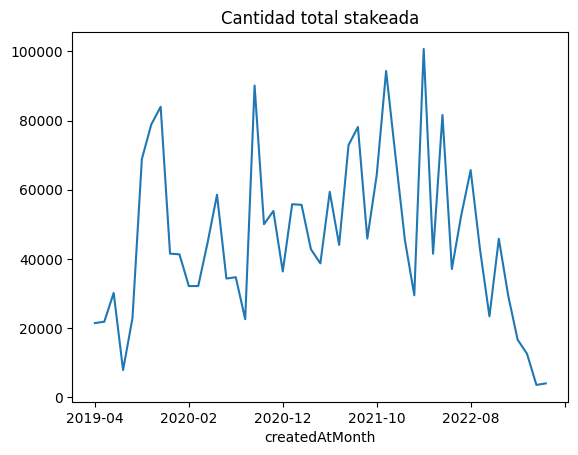

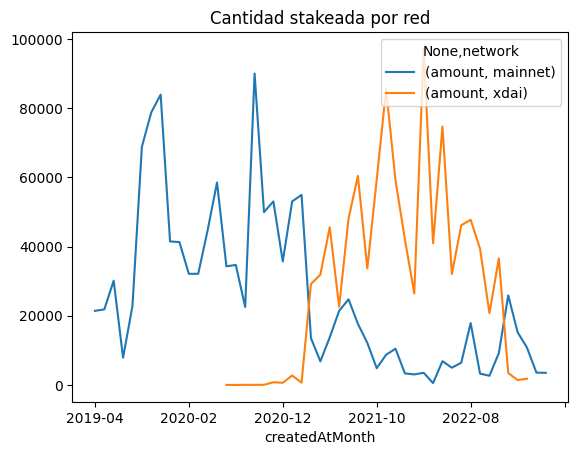

In [11]:
dfs = utils.get_df('dfs')

gbys = dfs.groupby(['network', 'createdAtMonth'])['amount'].sum().reset_index()
gbys['createdAtMonth'] = gbys['createdAtMonth'].dt.strftime('%Y-%m')
gbysp = gbys.pivot(index='createdAtMonth', columns=['network'])

gbysp.sum(axis=1).plot()
plt.title("Cantidad total stakeada")
gbysp.plot()
plt.title('Cantidad stakeada por red');

In [12]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']

    gbys = dfs.groupby(['createdAtMonth'] + cols)['amount'].mean().reset_index()
    gbys['createdAtMonth'] = gbys['createdAtMonth'].dt.strftime('%Y-%m')
    gbysp = gbys.pivot(index='createdAtMonth', columns=cols)
    # gbysp[('amount','total')] = gbysp.mean(axis=1)

    gbysp.plot()
    plt.title('Cantidad media en cada operación por red' + (' y estado de la DAO' if complejo else ''))

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

En xdai se nota que está muy correlacionado na con registered, con valores muy similares.

En mainnet parece que difieren un poco más los valores

In [13]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']
    
    gbys = dfs.groupby(['createdAtMonth'] + cols)['amount'].count().reset_index()
    gbys['createdAtMonth'] = gbys['createdAtMonth'].dt.strftime('%Y-%m')
    gbysp = gbys.pivot(index='createdAtMonth', columns=cols)
    # gbysp[('amount','total')] = gbysp.sum(axis=1)

    gbysp.plot()
    plt.title('Número de operaciones de staking');

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

En el caso de mainnet, a penas hay actividad en las DAOs de estado distinto a registered, pero en las DAOs de xdai, sí que hay un cambio significativo entre contar las DAOs no registradas o no.

Cuando aumenta el número de operaciones de staking, por lo general aumenta la cantidad media en cada operación, pues el umbral de boosting aumenta cuantas más propuestas haya boosteadas en una DAO (para evitar que haya demasiadas propuestas a la vez)

In [14]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']
        
    dfpr['boostedAtMonth'] = dfpr['boostedAt'].dt.to_period('M')

    # Por cada mes, por cada dao, calcular el número de propuestas boosteadas
    gbyp = dfpr.groupby(['boostedAtMonth', 'dao'] + cols)['boosted'].sum()
    # Por cada red, por cada mes, calcular el máximo de cada dao
    gbyp2 = gbyp.groupby(['boostedAtMonth'] + cols).max()

    gbyp2.reset_index().pivot(index='boostedAtMonth', columns=cols).plot()
    plt.title("Número máximo de propuestas boosteadas en cada DAO mes a mes");

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

<p style="color: red; font-size: 3em">¿El gráfico de arriba está bien?</p>
No me cuadra que haya una DAO con 120 propuestas en un mismo mes...

In [15]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']

    dfpr['boostedAtMonth'] = dfpr['boostedAt'].dt.to_period('M')

    # Por cada mes, por cada dao, calcular el número de propuestas boosteadas
    gbyp = dfpr.groupby(['boostedAtMonth', 'dao'] + cols)['boosted'].sum()
    # Por cada red, por cada mes, calcular la media de cada dao
    gbyp2 = gbyp.groupby(['boostedAtMonth'] + cols).mean()

    gbyp2.reset_index().pivot(index='boostedAtMonth', columns=cols).plot()
    plt.title("Número medio de propuestas boosteadas en cada DAO");

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

In [16]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']

    dfpr['notApproved'] = ~dfpr['approved']
    dfpr.groupby(['executedAtMonth'] + cols)['notApproved'].sum().reset_index().pivot(index='executedAtMonth', columns=cols).plot()
    plt.title('Número absoluto de propuestas no aceptadas por mes');

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

In [17]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']

    fig = dfpr.groupby(['executedAtMonth'] + cols)['approved'].mean().reset_index().pivot(index='executedAtMonth', columns=cols).plot(figsize=(10,4))
    plt.title('% de propuestas aceptadas por mes')
    display(utils.plot.save_fig(fig, 'boosting_predictor/pct_proposals_approved.png', showlegend=False, debug=True))

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

In [18]:
@widgets.interact
def plot_update(complejo = False):
    cols = ['network']
    
    if complejo:
        cols += ['daoRegister']

    _gb = dfpr.groupby(['executedAtMonth'] + cols)
    fig = _gb['boosted'].mean().reset_index().pivot(index='executedAtMonth', columns=cols).plot(figsize=(10,4))
    plt.title("Porcentaje de propuestas boosteadas")
    display(utils.plot.save_fig(fig, 'boosting_predictor/pct_proposals_boosted.png', showlegend=False, debug=True))

interactive(children=(Checkbox(value=False, description='complejo'), Output()), _dom_classes=('widget-interact…

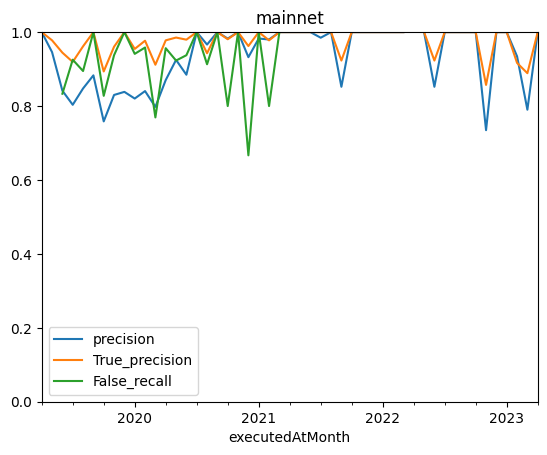

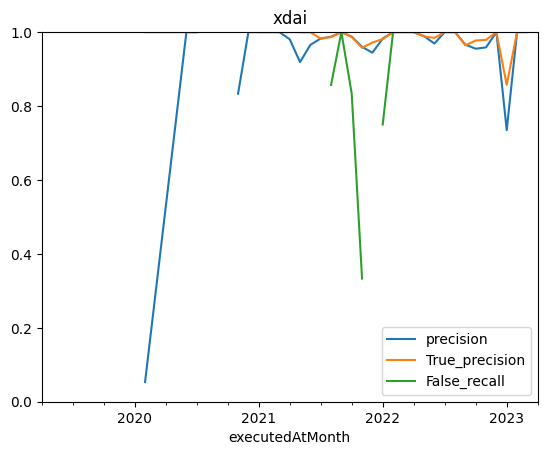

In [19]:
PREDICTOR = 'boosted'
E = 3

# Remove precission/recall/etc if 'len(data) < E', (for example, 3)
def _if_sup(d, k):
    return d.get(k, np.nan) if d.get('support', 0) >= E else np.nan

def row_p(x):
    cr = classification_report(y_true=x['approved'], y_pred=x[PREDICTOR], output_dict=True, zero_division=0)

    return pd.Series({
        'precision': _if_sup(cr['weighted avg'], 'precision'),
        # 'recall': _if_sup(cr['weighted avg'], 'recall'),
        # 'f1-score': _if_sup(cr['weighted avg'], 'f1-score'),
        # 'accuracy': cr['accuracy'],

        'True_precision': _if_sup(cr.get('True', {}), 'precision'),
        'False_recall': _if_sup(cr.get('False', {}), 'recall'),
    })

# Make the graphs start at the same point in time
aux_min = dfpr['executedAtMonth'].min()
aux_max = dfpr['executedAtMonth'].max()
for n in dfpr['network'].unique():
    dfpr[dfpr.network == n].groupby('executedAtMonth')[['approved', PREDICTOR]].apply(row_p).plot(xlim=(aux_min,aux_max), ylim=(0,1))
    plt.title(n)

La precisión para predecir que una propuesta no saldrá es muy mala, porque en general a penas hay casos de soporte

En el caso de que una propuesta sí salga, hay una precisión muy alta, pero esto es principalmente debido a que a penas hay propuestas que no salgan. Sin embargo, sí que hay bastantes propuestas que ganan pero no llegan a ser boosteadas, por lo que el recall no es TAN alto.

En el caso de mainnet, al principio no todas las propuestas eran boosteadas, y por lo tanto baja la precisión en ese periodo de tiempo.

### Confusion matrix pre/pos jul 2020

In [20]:
?widgets.DatePicker

Init signature: widgets.DatePicker(*args, **kwargs)
Docstring:     
Display a widget for picking dates.

Parameters
----------

value: datetime.date
    The current value of the widget.

disabled: bool
    Whether to disable user changes.

Examples
--------

>>> import datetime
>>> import ipywidgets as widgets
>>> date_pick = widgets.DatePicker()
>>> date_pick.value = datetime.date(2019, 7, 9)
Init docstring: Public constructor
File:           ~/Documents/GRASIA/daostack-notebooks/.direnv/python-3.11/lib/python3.11/site-packages/ipywidgets/widgets/widget_date.py
Type:           MetaHasTraits
Subclasses:     

In [21]:
from datetime import datetime, date

date_pick = widgets.DatePicker()
outputl = widgets.Output(layout={'border': '1px solid white'})
outputr = widgets.Output(layout={'border': '1px solid white'})
vbox = widgets.VBox([date_pick, widgets.HBox([outputl, outputr])])

@date_pick.observe
def show_class_date(change):
    assert change['type'] == 'change'
    date_pick = change['owner']
    dt = datetime(date_pick.value.year, date_pick.value.month, date_pick.value.day)
    
    outputl.clear_output()
    with outputl:
        display(plot_classification_report_2x2(dfpr[dfpr.executedAt <= dt], suptitle=f'Classification report (pre {dt.date()})'))
        
    outputr.clear_output()
    with outputr:
        display(plot_classification_report_2x2(dfpr[dfpr.executedAt > dt], suptitle=f'Classification report (pos {dt.date()})'))
    
date_pick.value=date(2020, 6, 11)
    
display(vbox)

Se puede observar notablemente la diferencia en **mainnet**

A la izquierda tenemos una precisión false del 50% (y true del 96%), aunque los recall se intercambian.

Sin embargo, a la derecha la precisión (después del incremento en el precio de Ethereum) la precisión aumenta del 73% al 98%, y **el recall de true pasa de 64% a 99%**. Es decir, el 99% de las propuestas que son aprobadas, han sido boosteadas.

### Versión "bonita" de 2x2 para el paper

y_true = approved, y_pred = boosted
              precision    recall  f1-score   support

       False       0.55      0.90      0.69       582
        True       0.98      0.87      0.92      3220

    accuracy                           0.87      3802
   macro avg       0.77      0.89      0.80      3802
weighted avg       0.91      0.87      0.88      3802

## mainnet only ##
              precision    recall  f1-score   support

       False       0.52      0.91      0.66       469
        True       0.97      0.79      0.87      1874

    accuracy                           0.81      2343
   macro avg       0.75      0.85      0.77      2343
weighted avg       0.88      0.81      0.83      2343

## xdai only ##
              precision    recall  f1-score   support

       False       0.76      0.85      0.80       113
        True       0.99      0.98      0.98      1346

    accuracy                           0.97      1459
   macro avg       0.87      0.91      0.89      1459
wei

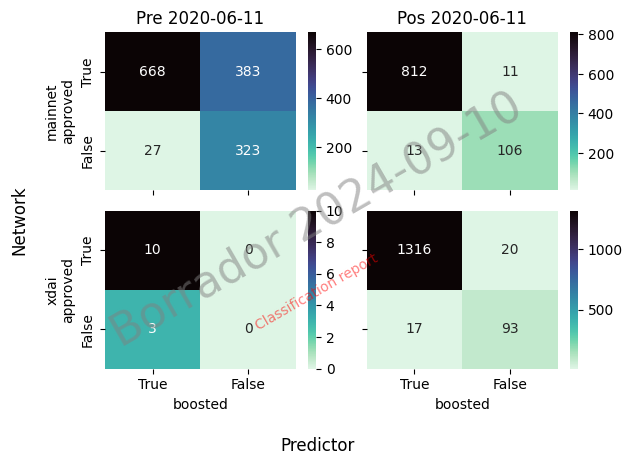

In [22]:
import sklearn

Y_AVAILABLE = ['mainnet', 'xdai']
PREDICTORES = ['stakes', 'boosted']

fig, axs = plt.subplots(ncols=len(Y_AVAILABLE), nrows=2, sharex=True, sharey=True, tight_layout=True)

fig.suptitle('Classification report')
fig.supxlabel("Predictor")
fig.supylabel('Network')

dt = datetime(date_pick.value.year, date_pick.value.month, date_pick.value.day)

print("y_true = approved, y_pred = boosted")
print(sklearn.metrics.classification_report(y_true=dfpr['approved'], y_pred=dfpr['boosted'], zero_division=0))
for i, n in enumerate(Y_AVAILABLE):
    dfprn = dfpr[dfpr['network'] == n]
    print(f"## {n} only ##")
    print(sklearn.metrics.classification_report(y_true=dfprn['approved'], y_pred=dfprn['boosted'], zero_division=0))

    # pre
    pre = dfprn[dfprn.executedAt <= dt]
    ct = pd.crosstab(pre['approved'], pre['boosted']).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    if True not in ct.columns:
        ct[True] = 0
    sns.heatmap(ct, annot=True, fmt='d', ax=axs[i][0], cmap=utils.plot.default_heatmap_cmap)

    # pos
    pos = dfprn[dfprn.executedAt > dt]
    ct = pd.crosstab(pos['approved'], pos['boosted']).sort_index(ascending=False).sort_index(axis=1, ascending=False)
    sns.heatmap(ct, annot=True, fmt='d', ax=axs[i][1], cmap=utils.plot.default_heatmap_cmap)

    # Hide labels on the middle
    # axs[i][0].set_xlabel(axs[i][0].get_xlabel() if i != 0 else '')
    axs[i][0].set_ylabel(f"{n}\n{axs[i][0].get_ylabel()}")
    axs[0][i].set_xlabel("")
    axs[i][1].set_ylabel("")
    
axs[0][0].set_title(f'Pre {dt.date()}')
axs[0][1].set_title(f'Pos {dt.date()}')
utils.plot.save_fig(fig, 'boosting_predictor/confusion_pre_pos_11J.png')

# ¿La predicción varía con el tamaño de la DAO? (A/B Youssef)

Replicamos lo del paper del HICSS dividiendo en dos grupos iguales por número de usuarios (usando la mediana, que es 23 usuarios).

**Versión paper**
- Grupo A: 23 miembros o menos
- Grupo B: 24 miembros o más

| | Usuarios | Propuestas |
|---|--------|------------|
| A | 95     | 178 |
| B | 6013   | 907 |

|   | Acc. | Prec. boost | Prec. non-boost |
|---|------|-------------|-----------------|
| A | 0.67 | 0.93 | 0.5 |
| B | 0.93 | 0.96 | 0.85 |

In [23]:
print(utils.get_df('dfd').groupby('network').size())
print(utils.dropDAOs(utils.get_df('dfd')).groupby('network').size())

network
mainnet    25
xdai       67
dtype: int64
network
mainnet    18
xdai        8
dtype: int64


In [24]:
dfd = utils.dropDAOs(utils.get_df('dfd')).reset_index()

dfdn = dfd[dfd.network == 'mainnet'].copy()
dfdn['ygroup'] = np.where(dfdn['hnusers'] <= 26, 'A', 'B')
dfdn['ygroup'] = dfdn['ygroup'].astype('category')

print("Median hnusers:", dfdn['hnusers'].median(), "in", len(dfdn), "DAOs")
_gb = dfdn.groupby('ygroup')
_table = _gb['dao'].count().to_frame()
_table['nusers'] = _gb['hnusers'].sum()
_table['proposals'] = _gb['nproposals'].sum()
_table

Median hnusers: 35.0 in 18 DAOs


dao  nusers  proposals
ygroup                        
A         8   123.0        528
B        10  6185.0       1804

Antes había 20 DAOs y ahora hay 25.

Siguen saliendo dos grupos iguales, en eso no ha cambiado mucho la cosa. Pero en el grupo A hay 20 usuarios más, mientras que en el grupo B hay 200.

Es notable que en el grupo A hay a penas 50 propuestas nuevas, mientras que en el grupo B hay **más del doble**.

El grupo A tiene el 2% de usuarios, pero el 10% de propuestas.

y_true = approved, y_pred = boosted
              precision    recall  f1-score   support

       False       0.51      0.91      0.65       442
        True       0.97      0.79      0.87      1866

    accuracy                           0.81      2308
   macro avg       0.74      0.85      0.76      2308
weighted avg       0.88      0.81      0.83      2308

## A only ##
              precision    recall  f1-score   support

       False       0.20      0.92      0.32        88
        True       0.94      0.24      0.38       438

    accuracy                           0.36       526
   macro avg       0.57      0.58      0.35       526
weighted avg       0.81      0.36      0.37       526

## B only ##
              precision    recall  f1-score   support

       False       0.85      0.91      0.88       354
        True       0.98      0.96      0.97      1428

    accuracy                           0.95      1782
   macro avg       0.91      0.93      0.92      1782
weighted avg

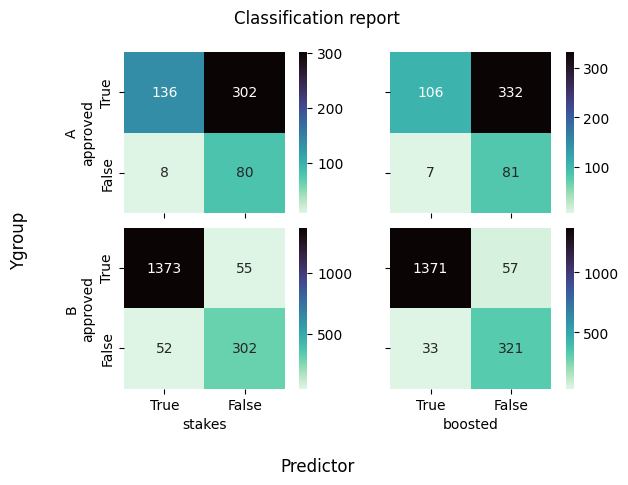

In [25]:
dfprn = dfpr[dfpr['network'] == 'mainnet']
dfprn = dfprn.merge(dfdn[['dao', 'ygroup']], left_on=['dao'], right_on=['dao'])
    
plot_classification_report_2x2(dfprn, supy='ygroup')

Entre paréntesis se encuentra el dato antiguo sacado del paper del HICSS

|   | Acc. | Prec. boost | Prec. non-boost |
|---|------|-------------|-----------------|
| A | 0.40 (0.67) | 0.94 (0.93) | 0.27 (0.5) |
| B | 0.96 (0.93) | 0.98 (0.96) | 0.83 (0.85) |

La única diferencia notable es que en el grupo B ha disminuido la precisión non-boosted notablemente del 85% al 57%. Es decir: **que no sea boosteada una propuesta del grupo B ya no es un buen indicador** de que va a ser rechazada.

La precisión comenzó a bajar cuando subió el precio de ethereum, pues de repente era mucho más caro hacer cualquier acción, tanto votar como hacer staking (y, por lo tanto, boostear). Al ser más caro, la gente sólo boostea cuando está muy muy segura de que la propuesta saldrá, y esta es la razón por la que la precisión non-boosted es tan baja. Además, que la mitad de las propuestas no-boosteadas acaben saliendo significa que se votan por mayoría absoluta.

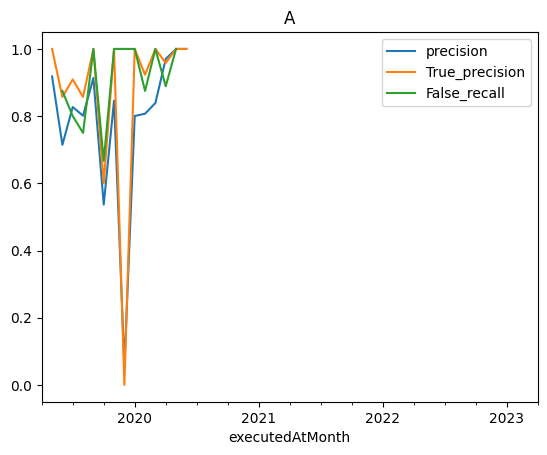

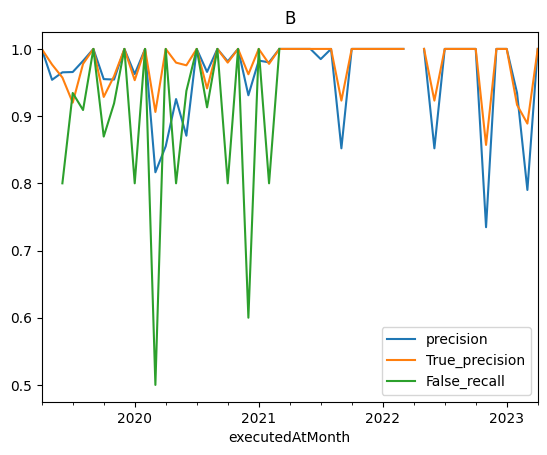

In [26]:
aux_min = dfpr['executedAtMonth'].min()
aux_max = dfpr['executedAtMonth'].max()

_aux = dfprn[dfprn['network'] == 'mainnet']
for n in sorted(_aux['ygroup'].unique()):
    _aux[_aux['ygroup'] == n].groupby('executedAtMonth')[['approved', PREDICTOR]].apply(row_p).plot(xlim=(aux_min,aux_max))
    plt.title(n)

## Replicar en xdai

In [27]:
dfdn = dfd[dfd.network == 'xdai'].copy()
dfdn['ygroup'] = np.where(dfdn['hnusers'] <= 5, 'A', 'B')
dfdn['ygroup'] = dfdn['ygroup'].astype('category')

print("Median hnusers:", dfdn['hnusers'].median(), "in", len(dfdn), "DAOs")
_gb = dfdn.groupby('ygroup')
_table = _gb['dao'].count().to_frame()
_table['nusers'] = _gb['hnusers'].sum()
_table['proposals'] = _gb['nproposals'].sum()
_table

Median hnusers: 6.0 in 8 DAOs


dao  nusers  proposals
ygroup                        
A         3    13.0         14
B         5  3251.0       1483

y_true = approved, y_pred = boosted
              precision    recall  f1-score   support

       False       0.79      0.83      0.81        99
        True       0.99      0.98      0.99      1338

    accuracy                           0.97      1437
   macro avg       0.89      0.91      0.90      1437
weighted avg       0.97      0.97      0.97      1437

## A only ##
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

## B only ##
              precision    recall  f1-score   support

       False       0.78      0.82      0.80        96
        True       0.99      0.98      0.99      1338

    accuracy                           0.97      1434
   macro avg       0.88      0.90      0.89      1434
weighted avg       0.97      0.97      0.97      1434



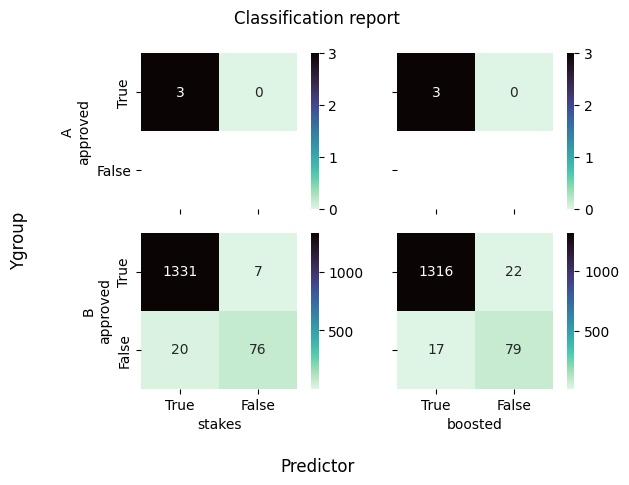

In [28]:
dfprn = dfpr[dfpr['network'] == 'xdai']
dfprn = dfprn.merge(dfdn[['dao', 'ygroup']], left_on=['dao'], right_on=['dao'])

plot_classification_report_2x2(dfprn, supy='ygroup')

## Hacer con GRUPO

In [29]:
dfg = utils.get_df('dfg')

dfg['ygroup'] = np.where(dfg['hnusers'] <= 26, 'A', 'B')
# dfg['ygroup'] = np.where(dfg['nproposals'] <= 30, 'Ap', 'Bp')
dfg['ygroup'] = dfg['ygroup'].astype('category')

print("Median hnusers:", dfg['hnusers'].median(), "in", len(dfg), "orgs")
print("Median number of proposals:", dfg['nproposals'].median())
_gb = dfg.groupby('ygroup')
_table = _gb.size().rename('cnt').to_frame()
_table['nusers'] = _gb['hnusers'].sum()
_table['proposals'] = _gb['nproposals'].sum()
_table

Median hnusers: 26.0 in 23 orgs
Median number of proposals: 30.0


cnt  nusers  proposals
ygroup                        
A        12     108        204
B        11    9104       3628

y_true = approved, y_pred = boosted
              precision    recall  f1-score   support

       False       0.54      0.90      0.68       544
        True       0.98      0.87      0.92      3204

    accuracy                           0.88      3748
   macro avg       0.76      0.88      0.80      3748
weighted avg       0.92      0.88      0.89      3748

## A only ##
              precision    recall  f1-score   support

       False       0.47      0.90      0.62        52
        True       0.94      0.61      0.74       134

    accuracy                           0.69       186
   macro avg       0.71      0.76      0.68       186
weighted avg       0.81      0.69      0.71       186

## B only ##
              precision    recall  f1-score   support

       False       0.55      0.89      0.68       492
        True       0.98      0.88      0.93      3070

    accuracy                           0.88      3562
   macro avg       0.77      0.89      0.81      3562
weighted avg

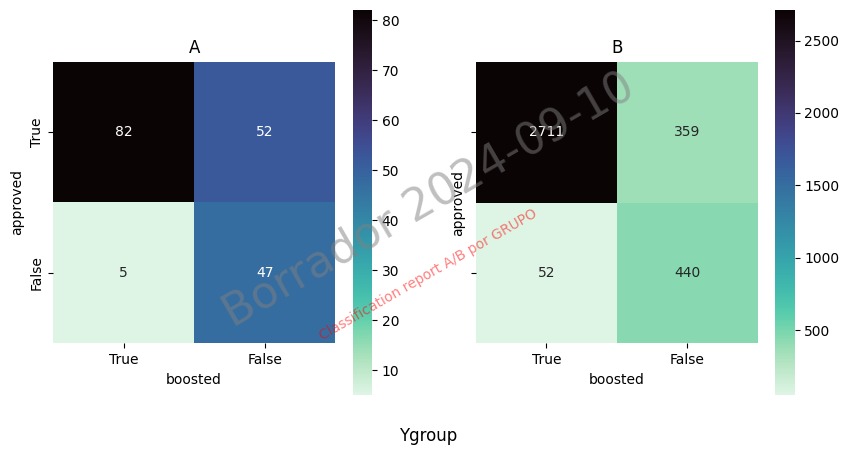

In [30]:
dfprm = dfpr.merge(dfg[['ygroup']], left_on='group', right_index=True)

fig = plot_classification_report_2x1(dfprm, supx='ygroup', suptitle="Classification report A/B por GRUPO")
fig.set_size_inches((10,5))
utils.plot.save_fig(fig, 'boosting_predictor/classification_youssef_grouped.png')

# Tabla resumen por DAO

In [31]:
dfh = utils.get_df('dfh') # from Prepare Data.ipynb
dfds = utils.get_df('dfds') # from stakers.ipynb

dfds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 91
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   network                    92 non-null     object        
 1   dao                        92 non-null     object        
 2   id                         92 non-null     object        
 3   name                       92 non-null     object        
 4   register                   92 non-null     object        
 5   nativeToken                92 non-null     object        
 6   nativeReputation           92 non-null     object        
 7   nusers                     92 non-null     int64         
 8   hnusers                    92 non-null     float64       
 9   firstUser                  91 non-null     datetime64[ns]
 10  firstActivity              67 non-null     datetime64[ns]
 11  lastActivity               67 non-null     datetime64[ns]
 12  lastVote  

saving to ../logseq/assets/nb_tables/boosting_predictor/resumen_bydao.png
/usr/bin/chromium
/usr/bin/chromium
Use ![Resumen de boosting como predictor por DAO](assets/nb_tables/boosting_predictor/resumen_bydao.png) to embed it in logseq


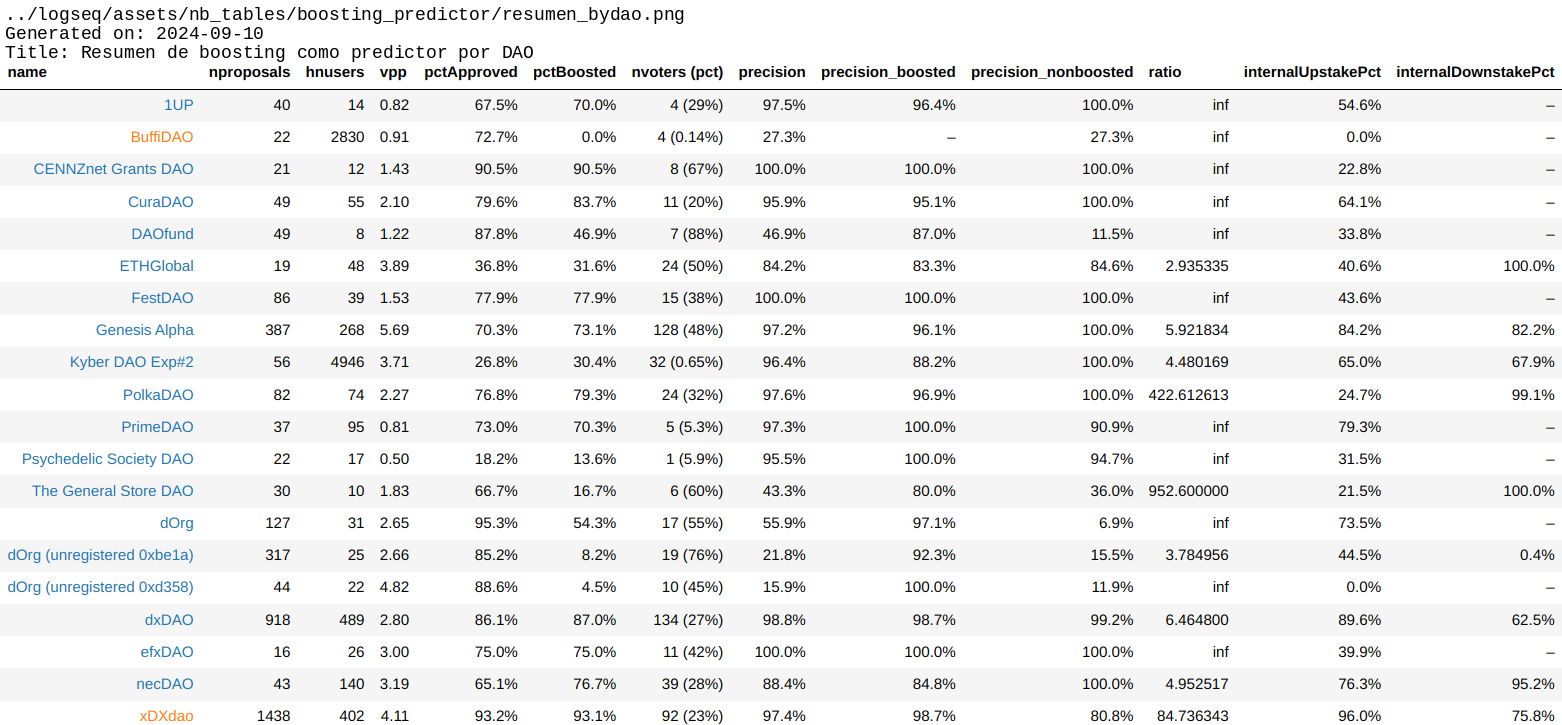

In [32]:
COLUMNS = ['name', 'nproposals', 'hnusers', 'vpp', 'pctApproved', 'pctBoosted', 'nvoters (pct)', 'precision', 'precision_boosted', 'precision_nonboosted', 'ratio', 'internalUpstakePct', 'internalDownstakePct']
INT_COLS = ['hnusers']
FLOAT_COLS = ['vpp']
PCT_COLS = ['pctApproved', 'pctBoosted', 'precision', 'precision_boosted', 'precision_nonboosted', 'internalUpstakePct', 'internalDownstakePct']
HIDDEN_COLS = ['network']

dfhgb = dfh.groupby(['network', 'dao'])

dfds['internalUpstakePct'] = (dfds['internalUpstake'] / dfds['upstake'])
dfds['internalDownstakePct'] = (dfds['internalDownstake'] / dfds['downstake'])
dfds['ratio'] = abs(dfds['upstake'] / dfds['downstake'])

_table = dfds.reset_index()
_table = _table.sort_values('nproposals', ascending=False).head(20)
_table = utils.tables.add_pct_col(_table, 'nvoters', 'hnusers')
_table[PCT_COLS] = _table[PCT_COLS]*100
# _table = utils.tables.add_pct_col(_table, 'internalUpstake', 'upstake')
# _table = utils.tables.add_pct_col(_table, 'internalDownstake', 'downstake')
_table = _table[COLUMNS + HIDDEN_COLS] # .rename(columns=COLUMNS_RENAME) # .set_index('Nombre')
_table = _table.sort_values('name')

s = _table.style.apply(utils.tables.nameColorByNetwork, axis=None) \
    .hide(HIDDEN_COLS, 'columns') \
    .format('{:.2f}'.format, subset=FLOAT_COLS) \
    .format('{:.0f}'.format, subset=INT_COLS) \
    .format(lambda x: '{:.1f}%'.format(x) if not np.isnan(x) else unicodedata.lookup('EN DASH'), subset=list(set(PCT_COLS).intersection(COLUMNS))) \
    .hide(axis='index')

utils.tables.save_table_image(s, 'boosting_predictor/resumen_bydao.png', title="Resumen de boosting como predictor por DAO", debug=True)